In [2]:
import pandas as pd
train_labels = pd.read_csv("/kaggle/input/image-matching-challenge-2025/train_labels.csv")
train_labels

,dataset,scene,image,rotation_matrix,translation_vector
0,imc2023_haiper,fountain,fountain_image_116.png,0.122655949;0.947713775;-0.294608417;0.1226706...,0.093771314;-0.803560988;2.062001533
1,imc2023_haiper,fountain,fountain_image_108.png,0.474305910;0.359108654;-0.803787832;0.2888416...,0.358946647;-0.797557548;1.910906929
2,imc2023_haiper,fountain,fountain_image_101.png,0.565115476;-0.138485064;-0.813305838;0.506678...,0.146922468;-0.981392596;2.009002852
3,imc2023_haiper,fountain,fountain_image_082.png,-0.308320392;-0.794654112;0.522937261;0.948141...,0.206413831;-1.174321103;3.667167680
4,imc2023_haiper,fountain,fountain_image_071.png,-0.569002830;-0.103808175;0.815757098;0.778745...,-0.015140892;-1.334052012;3.488936597
...,...,...,...,...,...
1940,stairs,stairs_split_2,stairs_split_2_1710453733751.png,0.961762441;-0.187990401;0.199179859;-0.177691...,-0.112850000;-3.521750000;-2.859750000
1941,stairs,stairs_split_2,stairs_split_2_1710453759963.png,0.237960308;0.580896704;-0.778417569;0.4077886...,-0.490768000;-3.064140000;3.008420000
1942,stairs,stairs_split_2,stairs_split_2_1710453805788.png,0.309067298;0.541767194;-0.781642957;0.4038963...,-0.572757000;0.885835000;4.987270000
1943,stairs,stairs_split_2,stairs_split_2_1710453765165.png,0.301920210;0.609614467;-0.732949103;0.5007116...,-0.135613000;-1.832910000;1.598790000


In [3]:
!pip install umap-learn
!pip install hdbscan
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 90.2 MB/s eta 0:00:00:00:0100:01


In [4]:
from transformers import CLIPProcessor, CLIPModel
import torch

# Load Pretrained CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [5]:
from PIL import Image
import os
import cv2 as cv

# Get image embeddings using CLIP
def get_image_embeddings(image_path: str):
    image = Image.open(image_path)

    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
        return clip_model.get_image_features(**inputs)

def pick_images(datasets, image_dir="/kaggle/input/image-matching-challenge-2025/train"):
    image_paths = []
    for _, row in train_labels[train_labels["dataset"].isin(datasets)].iterrows():
        path = os.path.join(image_dir, row["dataset"], row["image"])
        image_paths.append(path)
    return image_paths
        
datasets = ["imc2023_haiper"]
image_dir = "/kaggle/input/image-matching-challenge-2025/train"
image_paths = pick_images(datasets)
image_embeddings = torch.cat([get_image_embeddings(image_path) for image_path in image_paths])

print(image_embeddings.shape)

torch.Size([54, 512])


In [6]:
# Dimensionality reduction
import umap

umap_model = umap.UMAP(n_components = 5)
reduced_embeddings = umap_model.fit_transform(image_embeddings.cpu().numpy())
print(reduced_embeddings.shape)

(54, 5)


In [7]:
# Clustering
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=3)
clusterer.fit(reduced_embeddings)

HDBSCAN(min_cluster_size=3)

In [ ]:
print(f"HDBSCAN found {len(set(clusterer.labels_))} clusters")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

def visualize_clusters(umap_embeddings, cluster_labels, image_paths, num_samples=5):
    """
    Visualizes UMAP-reduced embeddings with HDBSCAN clusters and displays example images from a random cluster.
    
    Args:
        umap_embeddings (numpy.ndarray): 2D UMAP-reduced embeddings (N x 2).
        cluster_labels (numpy.ndarray): Cluster assignments for each image (N,).
        image_paths (list): List of file paths to the images (N,).
        num_samples (int): Number of images to display from a selected cluster.
    """

    unique_clusters = set(cluster_labels)
    palette = sns.color_palette("husl", len(unique_clusters))  # Generate colors for clusters
    
    # Scatter plot of clusters
    plt.figure(figsize=(10, 6))
    for cluster_id in unique_clusters:
        indices = np.where(cluster_labels == cluster_id)[0]
        plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], 
                    label=f"Cluster {cluster_id}" if cluster_id != -1 else "Outliers",
                    alpha=0.6, edgecolors='k', s=30, color=palette[cluster_id % len(palette)])
    
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.title("UMAP Visualization of Image Clusters")
    plt.legend()
    plt.show()

    # Pick a random cluster (excluding outliers, labeled as -1)
    valid_clusters = [c for c in unique_clusters if c != -1]
    if not valid_clusters:
        print("No valid clusters found.")
        return

    selected_cluster = random.choice(valid_clusters)
    print(f"\nDisplaying {num_samples} images from Cluster {selected_cluster}:")

    # Get image paths from the selected cluster
    cluster_indices = np.where(cluster_labels == selected_cluster)[0]
    sample_indices = random.sample(list(cluster_indices), min(num_samples, len(cluster_indices)))
    sample_images = [image_paths[i] for i in sample_indices]

    # Display images
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    for ax, img_path in zip(axes, sample_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
    plt.show()


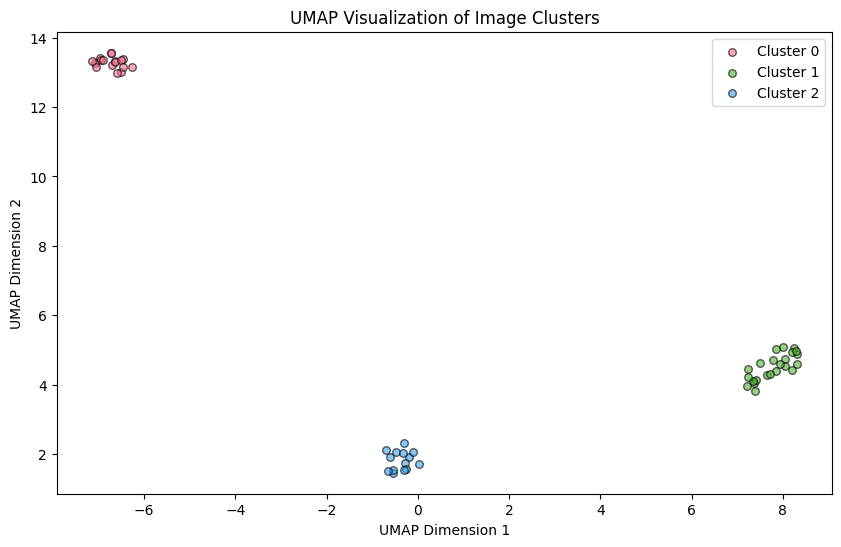


Displaying 5 images from Cluster 0:


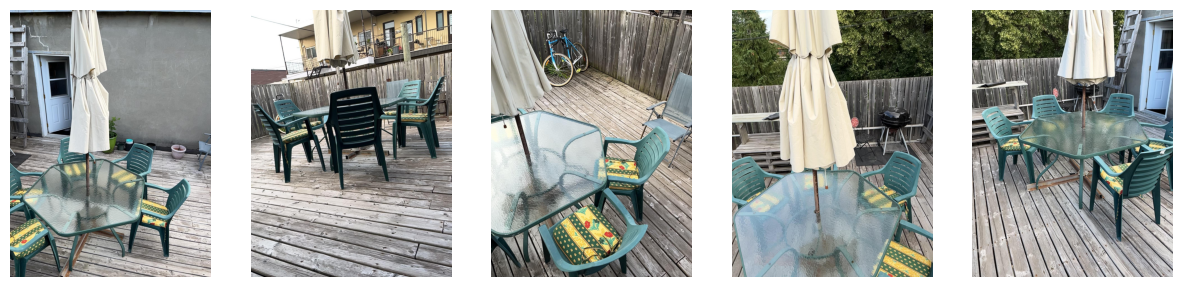

In [15]:
visualize_clusters(reduced_embeddings, clusterer.labels_, image_paths)

In [11]:
import os
import numpy as np
import pandas as pd
import pycolmap
from tqdm import tqdm

def run_colmap_on_cluster(image_paths, output_dir):
    """Runs COLMAP on a subset of images and returns poses."""
    os.makedirs(output_dir, exist_ok=True)
    
    database_path = os.path.join(output_dir, "database.db")
    image_dir = os.path.dirname(image_paths[0])  # Directory containing images
    image_list = [os.path.basename(img) for img in image_paths]  # Filenames only
    
    pycolmap.extract_features(
        database_path=database_path,
        image_path=image_dir,
        image_list=image_list,
        camera_mode=pycolmap.CameraMode.AUTO,
        device=pycolmap.Device('auto'),
        sift_options=pycolmap.SiftExtractionOptions(estimate_affine_shape=True),
    )
    
    pycolmap.match_exhaustive(database_path, device=pycolmap.Device('auto'))
    
    reconstructions = pycolmap.incremental_mapping(
        database_path=database_path,
        image_path=image_dir,
        output_path=output_dir,
    )
    
    # Extract poses (R, T) for each image
    poses = {}
    if reconstructions:
        reconstruction = next(iter(reconstructions.values()))
        for image_id, image in reconstruction.images.items():
            img_name = image.name
            rigid3d = image.cam_from_world
            R = rigid3d.rotation.matrix().ravel()
            R = ";".join(map(str, list(R)))
            T = rigid3d.translation
            T = ";".join(map(str, list(T)))
            poses[img_name] = (R, T)
    return poses

def process_clusters(image_paths, cluster_labels, output_dir="colmap_temp"):
    """Processes each cluster with COLMAP and compiles results."""
    results = []
    
    # Group images by cluster
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(image_paths[idx])
    
    # Process each cluster
    for cluster_id, cluster_images in tqdm(clusters.items()):
        if cluster_id == -1:
            # Outliers: No pose estimation
            for img in cluster_images:
                dataset = img.split(os.path.sep)[-2]
                results.append({
                    "dataset": dataset,
                    "scene": "outliers",
                    "image": os.path.basename(img),
                    "rotation_matrix": ";".join(map(str, [np.nan] * 9)),
                    "translation_vector": ";".join(map(str, [np.nan] * 3)),
                })
        else:
            # Run COLMAP on the cluster
            poses = run_colmap_on_cluster(cluster_images, f"{output_dir}/cluster_{cluster_id}")
            
            # Assign results
            for img in cluster_images:
                img_name = os.path.basename(img)
                dataset = img.split(os.path.sep)[-2]
                if img_name in poses:
                    R, T = poses[img_name]
                    results.append({
                        "dataset": dataset,
                        "scene": f"cluster_{cluster_id}",
                        "image": img_name,
                        "rotation_matrix": R,
                        "translation_vector": T,
                    })
                else:
                    # COLMAP failed to register this image
                    results.append({
                        "dataset": dataset,
                        "scene": f"cluster_{cluster_id}",
                        "image": img_name,
                        "rotation_matrix": ";".join(map(str, [np.nan] * 9)),
                        "translation_vector": ";".join(map(str, [np.nan] * 3)),
                    })
    return pd.DataFrame(results)

df_submission = process_clusters(image_paths, clusterer.labels_)
df_submission

100%|██████████| 3/3 [10:15<00:00, 205.10s/it]


,dataset,scene,image,rotation_matrix,translation_vector
0,imc2023_haiper,cluster_1,fountain_image_116.png,-0.9648873619480609;-0.12779172873212832;-0.22...,0.7311850296293376;-0.8717907975207398;1.95259...
1,imc2023_haiper,cluster_1,fountain_image_108.png,-0.588204951139047;0.5455168131413359;-0.59701...,0.6480374142799165;-0.49226158620216787;1.5527...
2,imc2023_haiper,cluster_1,fountain_image_101.png,-0.15154612690264235;0.8008631039519425;-0.579...,0.08319655065547377;-0.6629640317613378;1.6305...
3,imc2023_haiper,cluster_1,fountain_image_082.png,0.9090402110755593;-0.157703688572275;0.385714...,-0.2998005123575494;-1.6412508806353205;4.2161...
4,imc2023_haiper,cluster_1,fountain_image_071.png,0.38152646167178206;-0.7183317861496263;0.5817...,-0.08497607516918568;-1.9325138827613122;4.264...
5,imc2023_haiper,cluster_1,fountain_image_025.png,-0.4690920588490828;0.6043380014950018;-0.6439...,-0.12318472417423429;-1.5780577530487983;3.180...
6,imc2023_haiper,cluster_1,fountain_image_000.png,0.9260445855098951;0.371862041352172;0.0644984...,-0.8321134287910054;-1.9378645961074161;5.1226...
7,imc2023_haiper,cluster_1,fountain_image_007.png,0.709642176669996;0.6315922285498576;-0.312248...,-0.8330613154630989;-2.2251617593915713;3.7596...
8,imc2023_haiper,cluster_1,fountain_image_012.png,0.4566295307537911;0.7586487281142299;-0.46469...,-0.5649065808900282;-1.7069168293579875;3.1345...
9,imc2023_haiper,cluster_1,fountain_image_033.png,-0.8169465142866641;0.2769195079668969;-0.5058...,0.5257085695025402;-1.5697140953618294;3.52392...


In [12]:
def format_submission(df):
    """Formats the DataFrame into Kaggle's submission format."""
    return df[["dataset", "scene", "image", "rotation_matrix", "translation_vector"]]

# Save to CSV
submission = format_submission(df_submission)
submission.to_csv("train_results.csv", index=False)

In [13]:
import numpy as np
import pandas as pd
from itertools import combinations

def horn_method(src, dst):
    """Horn's absolute orientation algorithm for similarity transformation"""
    src_centroid = np.mean(src, axis=0)
    dst_centroid = np.mean(dst, axis=0)
    
    src_centered = src - src_centroid
    dst_centered = dst - dst_centroid
    
    H = src_centered.T @ dst_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    
    scale = np.linalg.norm(dst_centered) / np.linalg.norm(src_centered)
    t = dst_centroid - scale * R @ src_centroid
    
    return R, scale, t

def compute_mAA(pred_poses, gt_poses, thresholds):
    """Compute mAA for a single scene using RANSAC-like approach"""
    pred_centers = np.array([-pose[0].T @ pose[1] for pose in pred_poses])
    gt_centers = np.array([-pose[0].T @ pose[1] for pose in gt_poses])
    
    best_counts = np.zeros(len(thresholds))
    
    # Try all possible triplets
    for triplet in combinations(range(len(pred_centers)), 3):
        try:
            R, scale, t = horn_method(pred_centers[list(triplet)], gt_centers[list(triplet)])
            
            # Apply transformation to all points
            transformed = scale * (R @ pred_centers.T).T + t
            
            # Count inliers for each threshold
            distances = np.linalg.norm(transformed - gt_centers, axis=1)
            
            # Refine transformation with all inliers
            for i, thresh in enumerate(thresholds):
                inliers = np.where(distances < thresh)[0]
                if len(inliers) >= 3:
                    R_refined, scale_refined, t_refined = horn_method(
                        pred_centers[inliers], gt_centers[inliers])
                    transformed_refined = scale_refined * (R_refined @ pred_centers.T).T + t_refined
                    distances_refined = np.linalg.norm(transformed_refined - gt_centers, axis=1)
                    new_inliers = np.where(distances_refined < thresh)[0]
                    
                    if len(new_inliers) > best_counts[i]:
                        best_counts[i] = len(new_inliers)
        except:
            continue
    
    # Calculate accuracy at each threshold
    accuracies = best_counts / len(pred_centers)
    return np.mean(accuracies)

def parse_pose(row, isPred):
    """Parse rotation matrix and translation vector from CSV row"""
    try:
        R_col_name = 'rotation_matrix'
        R_col_name += '_pred' if isPred else '_gt'
        T_col_name = 'translation_vector'
        T_col_name += '_pred' if isPred else '_gt'
        R = np.array(row[R_col_name].split(';'), dtype=float).reshape(3,3)
        T = np.array(row[T_col_name].split(';'), dtype=float)
        return (R, T)
    except:
        return None

def parse_threshold(row):
    """Parse threshold vector from CSV row"""
    try:
        thresholds = np.array(row['thresholds'].split(';'), dtype=float)
        return thresholds
    except:
        return None

def evaluate_submission(pred_csv, gt_csv, thresholds_csv):
    """Full evaluation pipeline matching competition metrics"""
    pred = pd.read_csv(pred_csv)
    gt = pd.read_csv(gt_csv)
    thresholds = pd.read_csv(thresholds_csv)

    merged = pd.merge(pred, gt, 
                    on=['dataset', 'image'],
                    suffixes=('_pred', '_gt'))
    
    # Group by dataset and scene
    gt_groups = merged.groupby(['dataset', 'scene_gt'])
    pred_groups = merged.groupby(['dataset', 'scene_pred'])
    
    results = []
    
    for (dataset, scene), scene_data in gt_groups:
        if scene == 'outliers':
            continue
            
        # Get ground truth poses
        gt_poses = [parse_pose(row, False) for _, row in scene_data.iterrows()]
        gt_poses = [p for p in gt_poses if p is not None]

        gt_thresholds = parse_threshold(thresholds[(thresholds["dataset"]==dataset) & (thresholds["scene"]==scene)].iloc[0])
        
        if len(gt_poses) < 3:
            continue
            
        # Find best matching predicted cluster
        best_mAA = 0
        best_cluster_size = 0
        best_cluster_overlap = 0
        best_cluster_score = 0
        best_cluster = None
        
        for (pred_ds, pred_cluster), pred_data in pred_groups:
            if pred_ds != dataset or pred_cluster == 'outliers':
                continue
                
            # Get predicted poses
            pred_poses = [parse_pose(row, True) for _, row in pred_data.iterrows()]
            pred_poses = [p for p in pred_poses if p is not None]
            
            if len(pred_poses) < 3:
                continue
                
            # Calculate intersection
            common_images = set(scene_data['image']) & set(pred_data['image'])
            cluster_score = len(common_images) / len(pred_data)

            # Calculate mAA
            try:
                mAA = compute_mAA(pred_poses, gt_poses, gt_thresholds)
            except:
                mAA = 0
                
            if mAA > best_mAA or (mAA == best_mAA and cluster_score > best_cluster_score):
                best_mAA = mAA
                best_cluster_score = cluster_score
                best_cluster = pred_cluster
                best_cluster_overlap = len(common_images)
                best_cluster_size = len(pred_data)
        
        if best_cluster:
            results.append({
                'dataset': dataset,
                'scene': scene,
                'mAA': best_mAA,
                'cluster_overlap': best_cluster_overlap,
                'cluster_size': best_cluster_size,
                'mAA_counts': best_mAA*best_cluster_size
            })
    
    # Aggregate results
    if not results:
        return {'mean_mAA': 0, 'mean_clustering_score': 0, 'final_score': 0}
    
    df_results = pd.DataFrame(results)
    df_results_by_dataset = df_results.groupby("dataset")
    agg_cluster = df_results_by_dataset[["mAA_counts", "cluster_overlap", "cluster_size"]].sum()
    agg_cluster_scores = (agg_cluster["cluster_overlap"] / agg_cluster["cluster_size"])
    agg_mAA = (agg_cluster["mAA_counts"] / agg_cluster["cluster_size"])

    output = pd.concat([agg_mAA, agg_cluster_scores], names=["mAA", "cluster_scores"], axis=1)
    output = output.set_axis(["mAA", "cluster_scores"], axis=1)
    output["dataset_scores"] = 2*output["mAA"]*output["cluster_scores"] / (output["mAA"] + output["cluster_scores"])
    
    return output


thresholds_file = '/kaggle/input/image-matching-challenge-2025/train_thresholds.csv'
results = evaluate_submission('train_results.csv', '/kaggle/input/image-matching-challenge-2025/train_labels.csv', thresholds_file)
print(results)
print(f"Final Competition Score: {np.mean(results['dataset_scores'].to_list())*100:.2f}")

                     mAA  cluster_scores  dataset_scores
dataset                                                 
imc2023_haiper  0.222222        0.981481        0.362393
Final Competition Score: 36.24
